In [1]:
import joblib

model_folder = '../models_seq2seq/'

model_mar = joblib.load(model_folder+f'mar_rf_model.joblib')
model_jul = joblib.load(model_folder+f'jul_rf_model.joblib')
model_nov = joblib.load(model_folder+f'nov_rf_model.joblib')

scalers_mar = joblib.load(model_folder+f'mar_scalers_data.joblib')
scalers_jul = joblib.load(model_folder+f'jul_scalers_data.joblib')
scalers_nov = joblib.load(model_folder+f'nov_scalers_data.joblib')

In [2]:
import pandas as pd
data = pd.read_csv("../data/decomp/kusok_1.csv")  # Загрузить файл
hist = data[['full_date', '1']]
hist = hist.loc[hist['full_date'] > '2018-03-15']

In [3]:
import numpy as np
import pandas as pd
from itertools import cycle
from sklearn.preprocessing import StandardScaler

# ─── your preprocessing & feature functions (as you provided) ─────────────────

def create_date_features(dates_series):
    df = pd.DataFrame(index=dates_series)
    df['day_of_week'] = df.index.dayofweek
    df['month']       = df.index.month
    df['day_of_year'] = df.index.dayofyear
    for feat, period in [('day_of_week',7), ('month',12), ('day_of_year',365)]:
        df[f'{feat}_sin'] = np.sin(2*np.pi*df[feat]/period)
        df[f'{feat}_cos'] = np.cos(2*np.pi*df[feat]/period)
    return df.drop(columns=['day_of_week','month','day_of_year']).values

def preprocess_samples(samples_dict, data_scaler=None, y_scaler=None, fit_scalers=True, 
                       input_size=245, fcst_size=120):
    """
    X_data forms from first input_size values.
    X_dates forms from next fcst_size dates for which we need to forecast. Those are date features. 
    y is used to get only date if we don't fit scalers. If we fit scalers, we need real values.
        this can be in case of train preprocessing. Otherwise can be y values nans. 
    """
    X_data_list = []
    X_date_fs_list = []
    y_list = [] if fit_scalers else None

    # Loop over each sample DataFrame
    for key, df in samples_dict.items():
        # identify the single data column
        val_cols = [c for c in df.columns if c != 'full_date']
        if len(val_cols) != 1:
            raise ValueError(f"Expected exactly one data column in '{key}', got {val_cols}")
        col = val_cols[0]

        # extract values and dates
        values = df[col].values
        if len(values) < input_size + (fcst_size if fit_scalers else 0):
            raise ValueError(f"Not enough data in '{key}'. Need at least {input_size + fcst_size} rows.")

        # split features vs. targets
        X_data_list.append(values[:input_size])
        if fit_scalers:
            y_list.append(values[input_size: input_size + fcst_size])

        # build forecast-date features
        last_input_date = pd.to_datetime(df['full_date'].iloc[-1])
        fcst_dates = pd.date_range(start=last_input_date + pd.Timedelta(days=1),
                                   periods=fcst_size,
                                   freq='D')
        X_date_fs_list.append(create_date_features(fcst_dates))

    # stack into arrays
    X_data = np.array(X_data_list)[..., np.newaxis]   # shape (n, input_size, 1)
    X_dates = np.array(X_date_fs_list)                  # shape (n, fcst_size, n_feats)
    y       = np.array(y_list) if fit_scalers else None

    # fit or check scalers
    if fit_scalers:
        data_scaler = StandardScaler().fit(X_data.reshape(-1, 1))
        y_scaler    = StandardScaler().fit(y)
    else:
        if data_scaler is None:
            raise ValueError("Must provide a fitted data_scaler when fit_scalers=False.")
        # y_scaler may be None if you don't need to invert-transform

    # transform X (and y if present)
    X_data_scaled = data_scaler.transform(X_data.reshape(-1, 1)).reshape(X_data.shape)
    y_scaled = y_scaler.transform(y) if fit_scalers else None

    return X_data_scaled, X_dates, y_scaled, data_scaler, y_scaler


# ─── helper to slice out each seasonal window ──────────────────────────────────

def make_window(df, start_idx, input_size=245):
    w = df.iloc[start_idx:start_idx+input_size].copy()
    # rename the value column to the sample key
    w = w.rename(columns={'value': f'sample_{start_idx}'})
    return {f'sample_{start_idx}': w}

def make_inputs_for_forecast(hist_df, input_size=245, fcst_size=120,
                             data_scaler=None):
    # 1) last 245 values → X_data
    raw_vals = hist_df['value'].iloc[-input_size:].values
    X_data = raw_vals.reshape(1, input_size, 1)                  # (1,245,1)
    X_data = raw_vals.reshape(input_size, 1)                  # (1,245,1)
    X_data_scaled = data_scaler.transform(X_data.reshape(-1,1)) \
                             .reshape(input_size, 1)
                            #  .reshape(1, input_size, 1)

    # 2) next 120 dates → X_dates
    last_date   = pd.to_datetime(hist_df['full_date'].iloc[-1])
    future_dates= pd.date_range(last_date+pd.Timedelta(days=1),
                                periods=fcst_size)
    X_dates     = create_date_features(future_dates)            # (120,6)
    X_dates     = X_dates[None, ...]                            # (1,120,6)

    return X_data_scaled, X_dates

def prepare_traditional_data(X_data, X_dates):
    """Flatten data for traditional ML models"""
    # Flatten time series data and date features
    X_flat = np.concatenate([
        X_data.reshape(X_data.shape[0], -1),  # Flatten time series (245,1) -> 245
        X_dates.reshape(X_dates.shape[0], -1) # Flatten dates (120,6) -> 720
    ], axis=1)
    return X_flat


# ─── train your three seasonal models ───────────────────────────────────────────

# assume `df` has columns ['full_date','value'] sorted by date, length >=365
# e.g. df = pd.DataFrame({'full_date':pd.date_range(...), 'value':your_series})

# ─── iterative rolling‐forecast function ────────────────────────────────────────

def rolling_forecast(models, scalers, history_df,
                     input_size=245, fcst_size=120,
                     return_inputs=False):
    preds = []
    X_data_list = []
    y_true_list = []
    model_hist = history_df.copy().reset_index(drop=True)[:input_size]
    required_steps = history_df.shape[0] - input_size
    print('required_steps', required_steps)

    for model, scaler in zip(cycle(models), cycle(scalers)):
        # TODO: check if the model matches the date
        # grab the last 245
        # TODO: we shuld use values after 245 of history to finetune models  
        if len(preds) >= required_steps:
            break
        print(model_hist.shape)
        window = make_window(model_hist, len(model_hist) - input_size) 
        # we should preprocess test data with training scalers
        X_history, X_future_date_fs, _, _, _ = preprocess_samples(
            window,
            data_scaler=scaler['data'],
            y_scaler=scaler['y'],
            fit_scalers=False
        )
        # print(X_history.shape)
        # print(X_future_date_fs.shape)
        X_flat = prepare_traditional_data(X_history, X_future_date_fs)
        y_hat_scaled = model.predict(X_flat)
        y_hat = scaler['y'].inverse_transform(y_hat_scaled).ravel()
        preds.extend(y_hat)

        if return_inputs:
            X_data_list.append(X_history[0])  

            # —— pull only the numeric true values ——
            key = list(window.keys())[0]
            df_w = window[key]
            val_col = [c for c in df_w.columns if c != 'full_date'][0]
            true_vals = df_w[val_col].iloc[input_size:input_size+fcst_size].values
            y_true_list.append(true_vals)

        # append forecast to history
        last_date = pd.to_datetime(model_hist['full_date'].iloc[-1])
        print(last_date)
        next_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=fcst_size)
        new_df = pd.DataFrame({'full_date': next_dates, 'value': y_hat})
        model_hist = pd.concat([model_hist, new_df], ignore_index=True)

    if return_inputs:
        return np.array(preds), np.array(X_data_list), np.array(y_true_list)
    return np.array(preds)



In [4]:
# ─── run it ───────────────────────────────────────────────────────────────────
# history begins at march 16th 2018. so first model is march, then jul, nov. 
history_df = hist.rename(columns={'1':'value'})

scaler_list = [
    {'data':scalers_mar[0],'y':scalers_mar[1]},
    {'data':scalers_jul[0],'y':scalers_jul[1]},
    {'data':scalers_nov[0],'y':scalers_nov[1]},
]

preds, X_inputs, y_true_lst = rolling_forecast([model_mar, model_jul, model_nov], 
                          scaler_list, 
                          history_df=history_df,
                          input_size=245,
                          fcst_size=120,
                          return_inputs=True)

required_steps 692
(245, 2)
2018-11-15 00:00:00
(365, 2)
2019-03-15 00:00:00
(485, 2)
2019-07-13 00:00:00
(605, 2)
2019-11-10 00:00:00
(725, 2)
2020-03-09 00:00:00
(845, 2)
2020-07-07 00:00:00


In [13]:
test_df = history_df[245:].copy()
y_true = test_df['value']
preds = preds[:test_df.shape[0]]

Overall MSE : 1276.6848
Overall MAE : 23.6192
Overall MAPE: 33.68%


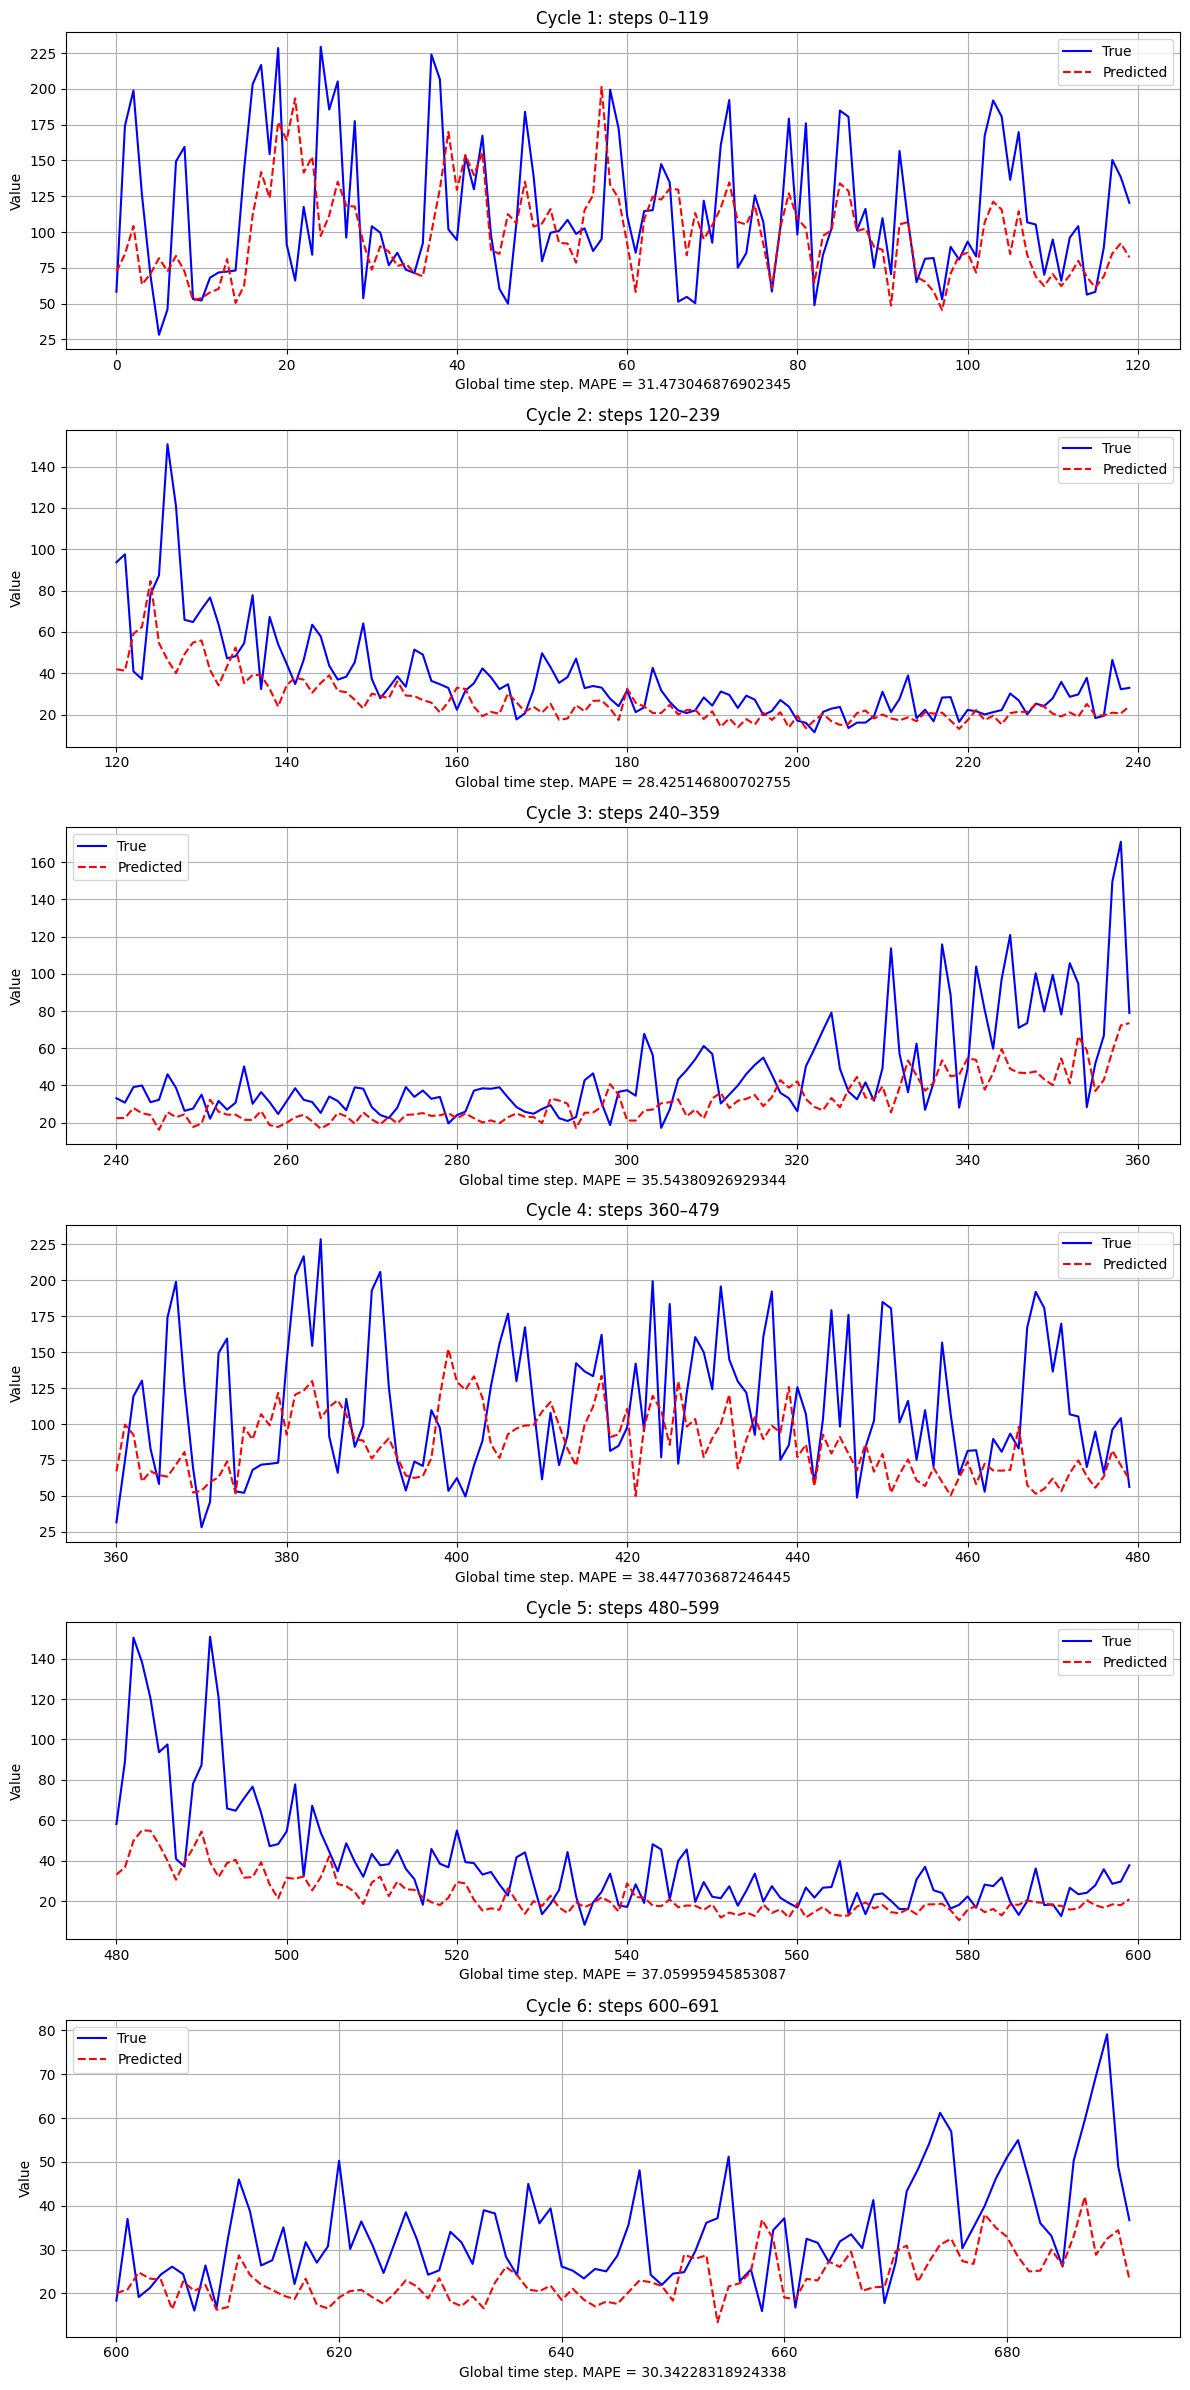

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ─── 2) Compute metrics ───────────────────────────────────────────────────────
mse  = mean_squared_error(y_true, preds)
mae  = mean_absolute_error(y_true, preds)
mape = np.mean(np.abs((y_true - preds) / (y_true + 1e-8))) * 100

print(f"Overall MSE : {mse:.4f}")
print(f"Overall MAE : {mae:.4f}")
print(f"Overall MAPE: {mape:.2f}%")

# ─── 3) Plot each 120-step block ───────────────────────────────────────────────
n_cycles = len(y_true_lst)
plt.figure(figsize=(12, 4 * n_cycles))

for i in range(n_cycles):
    start = i * 120
    end   = start + 120

    plt.subplot(n_cycles, 1, i + 1)

    if len(y_true[start:end]) < 120:
        end = start + len(y_true[start:end])

    t = np.arange(start, end)

    plt.plot(t, y_true[start:end], 'b-', label='True')
    plt.plot(t, preds[start:end],   'r--', label='Predicted')
    plt.title(f'Cycle {i+1}: steps {start}–{end-1}')

    local_mape = np.mean(np.abs((y_true[start:end] - preds[start:end]) / (y_true[start:end] + 1e-8))) * 100
    plt.xlabel(f'Global time step. MAPE = {local_mape}')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()